# Note: this tutorial is based on yet unpublished data and pipelines. Please do not share without explicit permission.

**Goal of this workshop**: 

Get acquainted with reduction of optical data, with a particular focus on ESPRESSO and on the differences with nIR data. The following notebook is fully functional, provided that you have: (1) python 3 and some very common packages that can be installed with anaconda; (2) some ESPRESSO data already processed through the ESO pipelines.

For the latter, I give you all the steps that you can apply yourself to any set of public or proprietary data to which you have access. This is a very disk space and time consuming process, thus I do not provide the reduced data here.

You will get this notebook and, on request and on collaborative basis, the full pipeline that I am writing for this reduction. This is a highly modular pipeline (to complement it with stuff like PCA and other methods) and compatible with ESPRESSO, HARPS-N and MAROON-X. I plan to make it public, it is currently in development but is already functional (with this same code, I have published my Pino et al., 2020 paper).

Write me to lorenzo.pino@inaf.it if interested!!!

# Data format and preparation

## ESO pipelines

Unlike with MAROON-X, we do not have an efficient team of people giving us the data in a usable form. We have to prepare our own data, using ESO pipelines.

ESO pipelines are a bit messy to install, but the ESO support team is very responsive and will help you in the process. I managed to install the pipelines on a Mac relatively effortlessly.

ESO pipelines are called "recipes", and can be run in different environments. Esorex is a command line tool. However, there is a convenient API called Esoreflex, which wraps Esorex in a more immediate form. This is what I use for the ESPRESSO pipelines.

From the README: Data reduction is demanding in terms of system resources. The user should have at least 16 GB of RAM, and 1 TB of free disk space. Better is to have 32 GB of RAM and 4 TB of free disk space. Please note that only the demo requires 30 GB of free space to be installed and generates additional 10 GB of products. This sets also minimum root directory space requirements for RPM installation. Data reduction for SINGLE modes (in particular not binned data) is slow, and may take 45 min. As some recipes parallelise code using OpenMP, data reduction is faster on multi-core systems.

... Yes, it is kind of a nightmare.

Create a folder tree:
1. ESPRESSO_observations/\<Run_name\>/data_with_raw_calibs
2. ESPRESSO_observations/\<Run_name\>/reflex_end_products

## Data download

Step 0 is to get the data from the ESO archive. There is a user friendly version of the archive (science portal) that contains pre-reduced spectra. These are good for a quick look, but not for science. So, we instead use the raw data portal (http://archive.eso.org/eso/eso_archive_main.html)

Let's search for WASP-189b, and select the ESPRESSO instrument. To make sure you do not lose any data, click on the Program ID. You will find that there are two public runs. The pipeline works with both, but let's use  0103.C-0889(C) which focuses on the dayside. In the window that opens, click on "FileList". That gives you a list of all science exposures in that run. We "Mark all", and "Request marked datasets (new service)".

We will not just need the science exposures, but also the calibrations, in order to run the pipeline. So let's "run association" of the **raw** calibrations (not processed). After the associatiton is done (it takes a while), we can download everything. I recommend the shell script.

Place the script for each run in the "data_with_raw_calibs", change permissions if needed (chmod u+x <script_name>) and run. You are downloading about 10 GB of data, so it may take a while. After everything is done, unzip the archives.

You should have lots of fits files. Most of them are calibrations, and may contain a date that does not coincide with the observational night. The observations have an associated raw2raw.xml, which associates the calibrations to the exposure. If some files are missing, repeat the process.

## Using esoreflex

You will need a configuration file of type ".kar". If you installed your ESO pipelines, you'll have an example to follow. In this drive (https://drive.google.com/drive/u/2/folders/1Xfu2wWyn8WO1DgOQsYmxj8gBMTMWUJ-W) I placed one example that I use.

1. Change the RAW_DATA_DIR and END-PRODUCTS-DIR according to your tree;
22. Tools -> Animate at Runtime -> 10

Launch!

Esoreflex requires some interaction. First, it will read the files, and present you with boxes to tick to select the files you'd like to reduce. If they are greyd out, it means that it could not find the calibrations. Go back to previous steps, and/or check your directory tree.

If you use a new .kar starting from the ESPRESSO pipeline examples, you will get a pop-up window. This shows the extracted spectra given the setup you curerently have. If this is satisfactory, click the option "Use the parameters above as initial values in the subsequent executions of this receipe". In this way you'll have no more pop-ups, and esoreflex will run on its own. In my own .kar files, I have already disabled the pop-up window, so you will not get it.

A little trick: you can interrupt the execution of the pipeline and resume at a different moment. Esoreflex knows which files you have reduced or not, and by default it should not overwrite them. If you wish to overwrite, find the "lazy mode" and disable it (so Esoreflex will actually do everything from the beginning.

This will take quite a while to run, and ESO claims that it runs faster on multi-core computers because there is some internal parallelization. I never tested that.

## Output of esoreflex 

In the output folder, esoreflex creates a folder with the date and time on which the workflow was called. So if you do parts of the analysis on different times, you will have the results under different folders. Within this folder you will find one subfolder for each exposure, which contains the final products. Only some of them are useful for us.

ESPRESSO has two fibers. Fiber A contains the spectra of the planet, and fiber B can be placed on different sources depending on the observer's choice. Usually, it is placed on sky, to monitor telluric emission.

**<OB_name>_S2D_BLAZE_A_<Esposure_UT_time>**: gives the blaze function in fiber A.

**<OB_name>_S2D_SKYSUB_A_<Esposure_UT_time>**: gives the 2-dimensional spectra from fiber A, after subtracting fiber B. This is necessary to remove the telluric emission lines, but it could in some cases introduce extra noise. This is what I am currently using and is suggested, but you may explore the impact of avoiding the sky subtraction.

In addition, there are many other files, for both fiber A and B. For example, there are flux calibrated spectra (currently, Feb 2022, ESPRESSO flux calibration is not completely reliable, and not accurate enough to recover the flux at the precision needed for exoplanet atmosphere applications). Finally, there are CCFs calculated by the pipeline with an algorithm which is very similar to the one I will give you in the next notebook (but much slower!).

From here on, we are on our own and we can start the data reduction.

# Data reduction

Compared to nIR data, optical data can be seen as "easier", in the sense that we have less telluric contamination. We have more contamination from the star, but if this is well behaved it is relatively simple to correct for (but this depends on application).

I thus provide you with a very simple data reduction pipeline, which *does not correct for tellurics*, and is already sufficient to reproduce results from the literature (e.g., Ehrenreich et al., 2021; Pino et al., 2020). Of course, this can be improved.

## Reading and preparing data

These are the operations that I suggest to perform before performing a retrieval on optical data:

1) Read data;

2) Apply color correction;

3) Move to the stellar rest frame to remove stellar lines;

4) Additional flattening and filtering of outliers.

These operations have been already mostly covered by Matteo and Megan. A pipeline such as theirs, works also on optical data. Here, I adopt a simplified version of those pipelines, which skips steps 2 and 4, to show you that we still get the result. While sub-optimal, I think this is interesting to see how reliable these detections are.

First, we import libraries, and open the fits files. Some tidying now will spare headaches later!

### Reading

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
from astropy import visualization

In [3]:
# Working with fits files. Works with different kinds of inputs (SKYSUB or not etc).

def read_sorted_hdus(input_data_directory, data_type, target_name):
    """S2D hdu structure (works for any S2D file):

    1: science
    2: errors
    3: data quality flag
    4: wavelength vacuum
    5: wavelength air
    6: pixel width vacuum
    7: pixel width air
    """
    
    # Get all data in folder of the specified type
    import glob
    data_files = np.array(glob.glob(input_data_directory + '*_{}_*'.format(data_type)))
    
    # Read date and time from the filename (standardized)
    date_time_observations = get_date_time_observations(data_files, data_type=data_type)
    
    # Sort exposures in time
    time_sorted_exposures_mask = compute_time_sorted_exposures_mask(date_time_observations)
    data_files_sorted = data_files[time_sorted_exposures_mask]

    # Open the fits and return them. Not the cheapest in terms of memory, but we'll use some of the info in the headers
    hdus = []
    for file_name in data_files_sorted:
        hdu = fits.open(file_name)
        if hdu[0].header['HIERARCH ESO OBS TARG NAME'] == target_name:
            hdus.append(hdu)    

    return hdus

def get_date_time_observations(data_files, data_type):
    """ Extract the date and time of an expsure from its name.
    """
    import re
    re.compile(data_type)

    date_time_observations = [] 

    for file in data_files:
        start = re.search(data_type + '_', file).end()

        date = file[start:start+10]
        time = file[start+11:start+23]

        date_time_observations.append([date, time])

    return date_time_observations

def compute_time_sorted_exposures_mask(date_time_observations):
    """ From strings to datetime objects
    """

    date_time_observations_datetime=[]
    from datetime import datetime
    for dt in date_time_observations:
        date_time_observations_datetime.append(datetime.strptime(dt[0] + ' ' + dt[1][:-4], "%Y-%m-%d %H:%M:%S"))    

    return np.argsort(date_time_observations_datetime)

In [4]:
input_data_directory = '/data2/pino/Data/observations/ESPRESSO/W189b_2019-06-02/'
data_type='S2D_SKYSUB_A'
target_name='HD 133112' # From the header of ESPRESSO files

# Read the sorted hdus
hdus_S2D = read_sorted_hdus(input_data_directory = input_data_directory, data_type=data_type, target_name=target_name)

len(hdus_S2D)

141

In [5]:
hdus_S2D[0][0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-10-08T23:02:05' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U2'         / ESO <TEL>                                      
INSTRUME= 'ESPRESSO'           / Instrument used.                               
OBJECT  = 'HD 133112'          / Original target.                               
RA      =           225.687392 / [deg] 15:02:44.9 RA (J2000) pointing           
DEC     =             -3.032

Now we load the actual spectra.

In [6]:
def read_S2D(hdus):
    """S2D hdu structure (works for any S2D file):

    1: science
    2: errors
    3: data quality flag
    4: wavelength vacuum
    5: wavelength air
    6: pixel width vacuum
    7: pixel width air

    Output: (exposure, order, pixel)

    Every physical order is represented twice in the S2D spectrum.

    From the manual:
    In the case of ESPRESSO, pupil slicing and anamorphic magnification are used to achieve high spectral resolution while using a grating with the same size as that of HARPS. The slit image on the detector is made of two ellipsoidal slices aligned in cross-dispersion direction. For the modes with the two slices of an order well separated on the CCD (SINGLEHR11, SINGLEHR21 and SINGLEUHR), each slice is extracted separately and treated as if it was an independent interference order. This results in each physical order being represented twice in the S2D extracted spectrum.
    """


    S2D_wavelengths_vacuum_bary = []
    S2D_spectra = []
    S2D_errors = []

    for n, hdu in enumerate(hdus):
        try:
            S2D_wavelengths_vacuum_bary.append(hdu[4].data)
        except:
            import pdb
            pdb.set_trace()
        S2D_spectra.append(hdu[1].data)
        S2D_errors.append(hdu[2].data)

    return np.array(S2D_wavelengths_vacuum_bary), np.array(S2D_spectra), np.array(S2D_errors)

In [7]:
# (n_exposures, n_orders, n_pixels)
S2D_wavelengths_vacuum_bary, S2D_spectra, S2D_errors = read_S2D(hdus_S2D)
np.shape(S2D_wavelengths_vacuum_bary)

(141, 170, 9111)

We want to look at the spectra. Since we will do that many times, let's define functions

In [7]:
# (exposure, order, pixel)

def plot_single_exposure(S2D_spectra, exp_index, cmap = matplotlib.cm.get_cmap('Blues')):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    norm = visualization.ImageNormalize(S2D_spectra[exp_index], interval=visualization.ZScaleInterval())
    imshow = ax.imshow(S2D_spectra[exp_index], norm=norm, origin='lower', aspect='auto', cmap=cmap, interpolation='none')
    ax.set_xlabel('Pixel')
    ax.set_ylabel('order')
    fig.colorbar(imshow)
    fig.tight_layout()
    
    return fig, ax

def plot_single_order(S2D_spectra, order_index, cmap = matplotlib.cm.get_cmap('Blues')):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    norm = visualization.ImageNormalize(S2D_spectra[:,order_index], interval=visualization.ZScaleInterval())
    imshow = ax.imshow(S2D_spectra[:,order_index], norm=norm, origin='lower', aspect='auto', cmap=cmap, interpolation='none')
    ax.set_xlabel('Pixel')
    ax.set_ylabel('Exposure')
    fig.colorbar(imshow)
    fig.tight_layout()
    
    return fig, ax

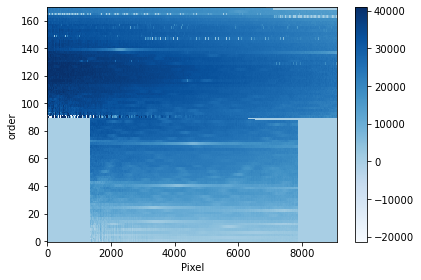

In [8]:
fig_exp, ax_exp = plot_single_exposure(S2D_spectra, exp_index=11)
plt.show()

We see that the 2 CCDs have different useful pixel numbers.

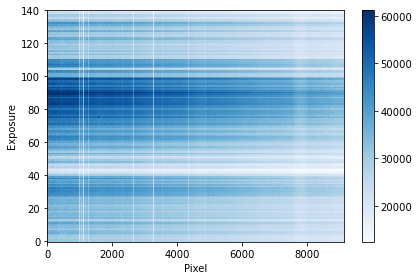

In [9]:
fig_order, ax_order = plot_single_order(S2D_spectra, order_index=130)
plt.show()

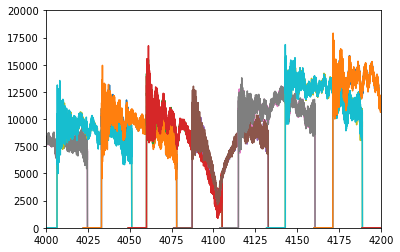

In [15]:
for w,s in zip(S2D_wavelengths_vacuum_bary[10], S2D_spectra[10]):
    plt.plot(w, s)
    
plt.ylim(0, 20000)
plt.xlim(4000, 4200)
plt.show()

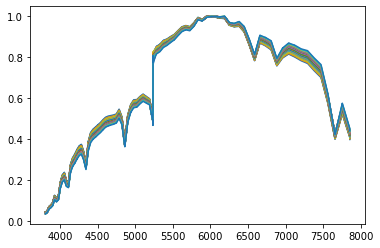

In [12]:
for n,(ww,ss) in enumerate(zip(S2D_wavelengths_vacuum_bary, S2D_spectra)):
    plt.plot(np.average(ww, axis=1), np.average(ss, axis=1)/np.max(np.average(ss, axis=1)), color='C{}'.format(n))

### Color-correction

Make the shape of the spectra consistent throughout the orders. This is not super-critical, and for the purpose of this tutorial I leave it out.

### Removal of stellar lines 

If your goal is to apply a Brogi&Line-style likelihood framework, this is a necessary step. However, with some other retrieval frameworks (e.g., Pino et al., 2020), it is possible to do this at a later stage, directly on the cross-correlation function. You could thus potentially cross-correlate at this stage (maybe include photoelectrons -> flux conversion, see later).

First, we create a common wavelength grid which on which we will provide the final spectra.

In [16]:
#
# Read BERV
#

BERVs = []
for hdu in hdus_S2D:
    BERVs.append(hdu[0].header['ESO QC BERV'])

#
# Calculate the laboratory vacuum wavelength solution, which we will use as a fixed, common grid throughout the analysis.
#

S2D_wavelengths_vacuum_laboratory = []

# The pipeline provides the wavelength array already shifted in the barycentric rest frame, so we shift it back.

from astropy.constants import c
c = (c.to('km s-1')).value

for n in range(len(S2D_wavelengths_vacuum_bary)):
    S2D_wavelengths_vacuum_laboratory.append(S2D_wavelengths_vacuum_bary[n] - S2D_wavelengths_vacuum_bary[n]*BERVs[n]/c)
S2D_wavelengths_vacuum_laboratory = np.array(S2D_wavelengths_vacuum_laboratory)


Now, we have to consider that the star is moving around the center of mass of the system. Thus, rather than calculating the spectra in the barycentric rest frame, we need to move to a system where the star is stationary.

To do that, we need to know which planetary phases we are sampling, and calculate the corresponding stellar shift. In the process, we also calculate and store the planet phases and the planet velocitie which we will use in the following.

We need to take care of the time conversions: the known ephemerid is given in BJD TDB, so we need to convert our exposure times to that same time scale and format. We use astropy for that. To do so, we calculate the BJD TDB time of every exposure.

In [17]:
from astropy import time
from astropy.coordinates import SkyCoord, EarthLocation

target_coordinates = SkyCoord.from_name(target_name)
site = EarthLocation.of_site('paranal')

time_observations = []

for hdu in hdus_S2D:
    exp_start=hdu[0].header['MJD-OBS']
    exp_dur=hdu[0].header['EXPTIME']
    time_observations.append(exp_start + exp_dur/(60.*60.*24.))

time_observations=time.Time(np.array(time_observations), format='mjd', scale='utc', location=site)

# We compute the time travel difference to the barycenter of the Solar System
dt_bary = time_observations.light_travel_time(target_coordinates)

# For the barycentric times, which are of our interest, the correct scale is TDB. (https://docs.astropy.org/en/stable/time/index.html#barycentric-and-heliocentric-light-travel-time-corrections).
bjd_time_observations = time_observations.tdb + dt_bary  

Now, we calculate the planet phases, the planet velocities and the stellar velocities.

In [19]:
T0 =   2456706.4545 # BJD TDB;
P_days = 2.7240330
r_AU = 0.05053

phases = ((bjd_time_observations.jd-T0)/P_days)%1
phases = np.where(phases < 0.5, 1+phases, phases) # To have them as a monotic sequence

r_km = r_AU*1.496e8
P_sec = P_days*24.*60.*60.
v_max = 2*np.pi*r_km/P_sec
planetary_velocities_during_transit = v_max*np.sin(phases*2.*np.pi)

k_star = 0.175 # km/s
stellar_phases = 0.5+phases # Change the sign of the RV for the star.
stellar_velocities_during_transit = k_star*np.sin(stellar_phases*2.*np.pi)

Finally, we calculate the shift in wavelength in a rest frame which is stationary with respect to the star.
$$\lambda_\mathrm{emit} = \lambda_\mathrm{obs} / (1 + v_\mathrm{emit}/c)\sim\lambda_\mathrm{obs}\cdot (1 - v_\mathrm{emit}/c)$$

In [20]:
S2D_wavelengths_vacuum_bary_stationary_star = []

for n in range(len(S2D_wavelengths_vacuum_bary)):
    S2D_wavelengths_vacuum_bary_stationary_star.append(S2D_wavelengths_vacuum_bary[n] - S2D_wavelengths_vacuum_bary[n]*stellar_velocities_during_transit[n]/c)
S2D_wavelengths_vacuum_bary_stationary_star = np.array(S2D_wavelengths_vacuum_bary_stationary_star)

We now move the spectra to the reference frame which co-moves with the star. The star does not move in this reference frame, thus it's best removed here.

Practically, we express these shifted spectra onto the commong wavelength grid (S2D_wavelengths_vacuum_laboratory), to be able to work with them as a time-series.

In [21]:
S2D_spectra_stellar_rest_frame = []
for n in range(len(S2D_spectra)):
    S2D_spectra_stellar_rest_frame.append([np.interp(w, wn, s) for w, wn, s in zip(S2D_wavelengths_vacuum_laboratory[n], S2D_wavelengths_vacuum_bary_stationary_star[n], S2D_spectra[n])])

You may have noticed that adjacent orders do not "match". That is becasue the units we have been working on is "total photoelectrons received during the exposure time". In this specific pipeline we could work in photoelectrons, but I think for some cases it may be better to work in units of energy which is also more closely related to flux (flux = energy per unit time, area, solid angle). So let's calcuate howmuch energy has been deposited in every single pixel.

For each pixel, we have to multiply by the total number of photons that hit it by the energy carreid by that photon. This is $h\nu$ or $\hbar/\lambda$. We neglect the constants, because we will normalize everything anyways. Note that we are assuming a single energy for all photoeleectrons falling on one pixel. You can verify yourself that this is a good approximation.

In [22]:
wave_bins = []

for n,w in enumerate(S2D_wavelengths_vacuum_laboratory[0]):
    
    #Compute the symmetric bins that cover the entire axis of wavelegths for a given set of wavelengths where the spectrum is known.
    #First bin extrapolated as identical to the second, and last bin to the previous.
    
    wave_bins.append([])
    wave_bins[n] = [ [(w[i-1] + w[i])/2.,(w[i] + w[i+1])/2.] for i in range(1,len(w)-1)]
    wave_bins[n].insert(0, [w[0] - (w[1] - w[0])/2., w[0] + (w[1] - w[0])/2. ])
    wave_bins[n].append([w[-1] - (w[-1] - w[-2])/2., w[-1] + (w[-1] - w[-2])/2. ])

wave_bins = np.array(wave_bins)
    
S2D_spectra_stellar_rest_frame = S2D_spectra_stellar_rest_frame/np.diff(wave_bins, axis=2)[:,:,0][None,:] # Now this is unit of total energy deposited in the pixel during the exposure time

We can now verify that the downwar slope is gone, and each order naturally goes into the next one. Spectral lines now have the correct shape. The "jumps" you can still see are not real, and are instead due to the high noise found in the blue part of each order because of the blaze function.

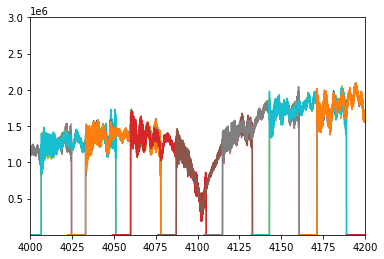

In [30]:
for w,s in zip(S2D_wavelengths_vacuum_laboratory[10], S2D_spectra_stellar_rest_frame[10]):
    plt.plot(w, s)
    
np.save('S2D_spectra_stellar_rest_frame_with_star_included_W189', S2D_spectra_stellar_rest_frame)
    
plt.ylim(1.e3, 3.e6)
plt.xlim(4000, 4200)
plt.show()

Our spectra are finally ready to remove the stellar lines. To do that, we use the same trick employed by PCA. Since telluric correction is much less important in the optical, we ignore that, and we can use a much simpler method. We simply build a master spectrum by taking a median in time of all the spectra, while we are in the star rest frame. The planet is moving, and it is not removed. Tellurics are not removed because they vary in time.

However, right now, the trick would not work because we have variable throughput during the night, and the median would give nonsense results. So let's first bring all the spectra to a common level. We do this order by order, because we did not perform a color-correction. I do this order by order also when I do perform the color-correction, because I think this is the most reliable way (color-correction still corrects inter-order continuum variations).

(141, 170, 9111)
(141, 170, 9111)


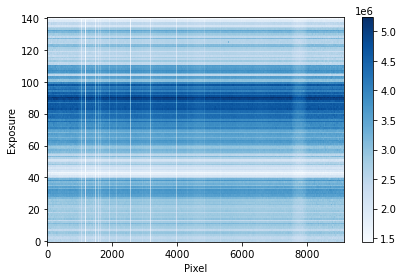

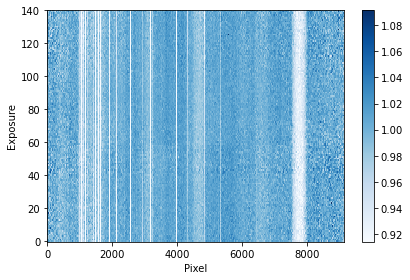

In [31]:
# Take the two central quartes of each order
i1 = 2277
i2=6833

S2D_spectra_stellar_rest_frame_rescaled = []
for s in S2D_spectra_stellar_rest_frame:
    S2D_spectra_stellar_rest_frame_rescaled.append(s/np.average(s[:,i1:i2], axis=1)[:,None])
S2D_spectra_stellar_rest_frame_rescaled = np.array(S2D_spectra_stellar_rest_frame_rescaled)

    
print(np.shape(S2D_spectra_stellar_rest_frame))
print(np.shape(S2D_spectra_stellar_rest_frame_rescaled))
    
fig_order, ax_order = plot_single_order(S2D_spectra_stellar_rest_frame, order_index=130)
fig_order_rescaled, ax_order_rescaled = plot_single_order(S2D_spectra_stellar_rest_frame_rescaled, order_index=130)

Now that the spectra are **rescaled** we can  **normalize** them by a master stellar spectrum (which contains some tellurics as well).

<ipython-input-34-4379e080b332>:4: RuntimeWarning: divide by zero encountered in true_divide
  S2D_spectra_stellar_rest_frame_normalized.append(s/median_S2D_spectra_stellar_rest_frame_rescaled)
<ipython-input-34-4379e080b332>:4: RuntimeWarning: invalid value encountered in true_divide
  S2D_spectra_stellar_rest_frame_normalized.append(s/median_S2D_spectra_stellar_rest_frame_rescaled)


(-0.1, 1.5)

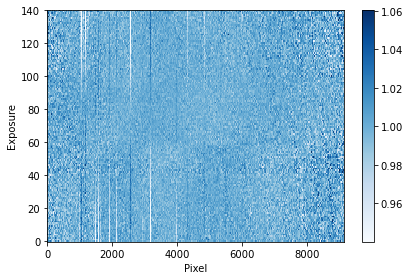

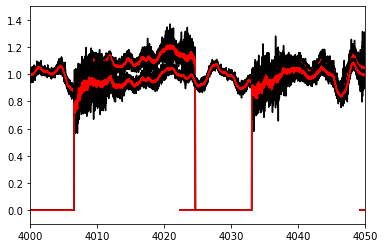

In [34]:
S2D_spectra_stellar_rest_frame_normalized = []
median_S2D_spectra_stellar_rest_frame_rescaled = np.median(S2D_spectra_stellar_rest_frame_rescaled, axis=0)
for s in S2D_spectra_stellar_rest_frame_rescaled:
    S2D_spectra_stellar_rest_frame_normalized.append(s/median_S2D_spectra_stellar_rest_frame_rescaled)
S2D_spectra_stellar_rest_frame_normalized = np.array(S2D_spectra_stellar_rest_frame_normalized)

fig_order_normalized, ax_order_normalized = plot_single_order(S2D_spectra_stellar_rest_frame_normalized, order_index=131)

# Plot master ontop of one exposure
plt.figure()
for o in range(170):
    plt.plot(S2D_wavelengths_vacuum_laboratory[50, o], S2D_spectra_stellar_rest_frame_rescaled[50, o], 'k', S2D_wavelengths_vacuum_laboratory[50, o], median_S2D_spectra_stellar_rest_frame_rescaled[o], 'r')

plt.xlim(4000, 4050)
plt.ylim(-0.1, 1.5)

Remember that the first orders have less pixels? When we divide by zero we get a warning. If we are not extremely careful, our cross-correlations and likelihoods will make no sense. I thus prefer to set nans to zeros, which is the null value for the binary mask cross-correlations (if you use other methods, you may need to set it to one, or other values

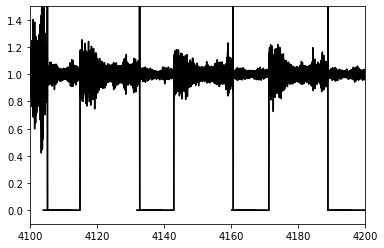

In [35]:
S2D_spectra_stellar_rest_frame_normalized = np.nan_to_num(S2D_spectra_stellar_rest_frame_normalized)

# Plot final spectra
plt.figure()
for o in range(170):
    plt.plot(S2D_wavelengths_vacuum_laboratory[50, o], S2D_spectra_stellar_rest_frame_normalized[50, o], 'k')

plt.xlim(4100, 4200)
plt.ylim(-0.1, 1.5)

np.save('S2D_wavelengths_vacuum_laboratory_W189', S2D_wavelengths_vacuum_laboratory)
np.save('S2D_spectra_barycentric_normalized_W189', S2D_spectra_stellar_rest_frame_normalized)

And we are ready to cross-correlate! Of course, you should be aware that we have not corrected for tellurics. While this can be fine for the bluest orders, for example if you focus on neutral iron, or it could be fine for a quick look, you probably want to implement a telluric correction or at least mask out the contaminated regions before proceeding.

Also, note how the singal to noise is strongly varying with wavelength. This is something that we need to consider when cross-correlating with yout favorite method. Did you already guess why the noise in the blue parts of the order is so high?

(4100.0, 4200.0)

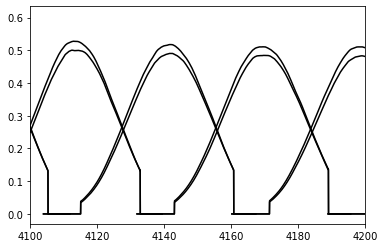

In [36]:
import glob
data_files_A_blaze = glob.glob(input_data_directory + '*BLAZE_A_*')
blaze_profiles = fits.open(data_files_A_blaze[0])[1].data

for w, b in zip(S2D_wavelengths_vacuum_laboratory[0], blaze_profiles):
    plt.plot(w, b, 'k')
    
plt.xlim(4100, 4200)

Typically, two more operations can be performed on data, which will improve the significance. ESPRESSO is a good instruments, thus the improvement is only marginal. I do not include them here. In the full pipeline, I will implement those methods.
1. High-pass filtering to remove smooth variations (imperfect blaze correction or color-correction, ...)
2. Removal of outliers (cosmic rays etc).
In ESPRESSO, the first step is important for publishing since there is an effect called "wiggles", which are low frequency oscillations observed ontop of the specrta, with phase change typically occurring at half of the night.